## Import

In [1]:
# !pip install pandas
# !pip install numpy
# # install sklearn
# !pip install scikit-learn
# !pip install tqdm
# !pip install seaborn
# !pip install prophet

In [2]:
import random
import pandas as pd
import numpy as np
import os
import re
import glob


from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from tqdm.auto import tqdm
from sklearn.model_selection import TimeSeriesSplit
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import seaborn as sns
import matplotlib.pyplot as plt

from prophet import Prophet

import gc
import warnings
warnings.filterwarnings(action='ignore')

# Device & Path

In [3]:
from decimal import ROUND_HALF_UP, Decimal

# Device & Path

In [4]:
def prep_prices(df):

    from decimal import ROUND_HALF_UP, Decimal

    pcols = ['open', 'high', 'low', 'close']

    #df.ExpectedDividend.fillna(0,inplace=True) # No column 'ExpectedDividend' in the given data

    def qround(x):
        return float(Decimal(str(x)).quantize(Decimal('0.1'), rounding=ROUND_HALF_UP))

    def adjust_prices(df_code):
        df_code = df_code.sort_values("date", ascending=False)
        #df_code.loc[:, "CumAdjust"] = df_code["AdjustmentFactor"].cumprod() # No column 'AdjustmentFactor' in the given data

        # generate adjusted prices
        for p in pcols:
            df_code.loc[:, p] = df_code[p].apply(qround)
        df_code.loc[:, "volume"] = df_code["volume"]
        df_code.ffill(inplace=True)
        df_code.bfill(inplace=True)

        # generate and fill Targets
        #df_code.loc[:, "Target"] = df_code.Close.pct_change().shift(-2).fillna(df_code.Target).fillna(0) # No column 'Target' in the given data
        #df_code.Target.fillna(0,inplace=True)

        return df_code

    # generate Adjusted
    df = df.sort_values(["code", "date"])
    df = df.groupby("code").apply(adjust_prices).reset_index(drop=True)
    df = df.sort_values("date")
    return df


In [ ]:
# device = torch.device('mps:0' if torch.backends.mps.is_available() else 'cpu')
# torch.backends.mps.is_available()

In [5]:
# PATH
DATA_PATH  = '/kaggle/input/dacon-stock-price'
TRAIN_PATH = os.path.join(DATA_PATH, 'train')
TRAIN_CSV  = os.path.join(DATA_PATH, 'train.csv')
SAMPLE_PATH = os.path.join(DATA_PATH, 'sample_submission.csv')

## Hyperparameter Setting

In [6]:
CFG = {
    'IMG_SIZE':224,
    'EPOCHS':1,
    'LEARNING_RATE':3e-4,
    'BATCH_SIZE':64,
    'SEED':41
}

## Fixed RandomSeed

In [7]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    # torch.manual_seed(seed)
    # torch.cuda.manual_seed(seed)
    # torch.backends.cudnn.deterministic = True
    # torch.backends.cudnn.benchmark = True


seed_everything(CFG['SEED']) # Seed 고정

## Data Pre-processing

In [8]:
df_train = pd.read_csv(TRAIN_CSV)
df_ss = pd.read_csv(SAMPLE_PATH)
df_train

,일자,종목코드,종목명,거래량,시가,고가,저가,종가
0,20210601,A060310,3S,166690,2890,2970,2885,2920
1,20210601,A095570,AJ네트웍스,63836,5860,5940,5750,5780
2,20210601,A006840,AK홀딩스,103691,35500,35600,34150,34400
3,20210601,A054620,APS,462544,14600,14950,13800,14950
4,20210601,A265520,AP시스템,131987,29150,29150,28800,29050
...,...,...,...,...,...,...,...,...
987995,20230530,A189980,흥국에프엔비,272284,3005,3035,2955,2980
987996,20230530,A000540,흥국화재,50218,3250,3255,3195,3215
987997,20230530,A003280,흥아해운,130664,1344,1395,1340,1370
987998,20230530,A037440,희림,141932,9170,9260,9170,9200


## columns
1. '일자': 이 컬럼은 특정 거래가 발생한 날짜를 나타냅니다. "YYYY-MM-DD" 형식으로 표현됩니다.

2. '종목코드': 각각의 주식을 식별하는 고유한 코드입니다. 한국의 경우 종목코드는 대부분 6자리 숫자로 이루어져 있습니다. (ex - A060310)

3. '종목명': 주식의 공식 이름을 나타냅니다. 이 이름은 주로 회사의 이름을 반영하며, 시장에서 해당 주식을 찾을 때 사용됩니다.

4. '거래량': 특정 일자에 해당 주식이 거래된 총 주식 수를 나타냅니다. 거래량은 시장의 활동 수준과 관심도를 반영하는 중요한 지표입니다.

5. '시가': 주식 시장이 개장했을 때의 첫 거래 가격을 의미합니다. 이는 해당 날의 시장 흐름을 이해하는데 도움이 됩니다.

6. '고가': 특정 일자에 해당 주식이 거래된 가장 높은 가격을 나타냅니다.

7. '저가': 특정 일자에 해당 주식이 거래된 가장 낮은 가격을 나타냅니다.

8. '종가': 주식 시장이 마감했을 때의 마지막 거래 가격을 의미합니다. 종가는 해당 일의 주식 가격 변동을 반영하며, 이후의 시장 분석에 중요한 기준이 됩니다.

In [9]:
# change columns name
df = df_train.rename(columns={
    '일자': 'date',
    '종목코드': 'code',
    '종목명': 'name',
    '거래량': 'volume',
    '시가': 'open',
    '고가': 'high',
    '저가': 'low',
    '종가': 'close'
})
df.head(5)

,date,code,name,volume,open,high,low,close
0,20210601,A060310,3S,166690,2890,2970,2885,2920
1,20210601,A095570,AJ네트웍스,63836,5860,5940,5750,5780
2,20210601,A006840,AK홀딩스,103691,35500,35600,34150,34400
3,20210601,A054620,APS,462544,14600,14950,13800,14950
4,20210601,A265520,AP시스템,131987,29150,29150,28800,29050


In [10]:
# datetime
df['date'] = pd.to_datetime(df['date'], format='%Y%m%d')
df.dtypes

date      datetime64[ns]
code              object
name              object
volume             int64
open               int64
high               int64
low                int64
close              int64
dtype: object

In [11]:
# min max data
print(f'min of data is {df.date.min()}')
print(f'max of date is {df.date.max()}')
print(f'sum of days are {df.date.max()-df.date.min()}')

df_test = df[df['code']=='A238490'].copy()
# weekend
df_test['is_weekend'] = df_test['date'].apply(lambda x: x.weekday() >= 5)

# 'is_weekend' columns False count
weekday_count = df_test[~df_test['is_weekend']].shape[0]

print(f"Number of weekdays: {weekday_count}")

min of data is 2021-06-01 00:00:00
max of date is 2023-05-30 00:00:00
sum of days are 728 days 00:00:00
Number of weekdays: 494


In [12]:
df_price = df.pivot(index='date', columns='code', values='close')
df_price

code,A000020,A000040,A000050,A000070,A000080,A000100,A000120,A000140,A000150,A000180,...,A363280,A365590,A368770,A369370,A373200,A375500,A378850,A383220,A383310,A383800
date,,,,,,,,,,,,,,,,,,,,,
2021-06-01,14600,1175,14950,114000,39600,65200,169500,18900,83900,2900,...,28450,2170,2730,2180,2250,135000,5980,492500,148700,11000
2021-06-02,14500,1210,15100,114500,40100,64300,168500,19300,90000,3005,...,27750,2170,2230,2195,2275,138000,5940,483000,146000,10700
2021-06-03,14600,1200,15400,114500,39900,64200,170000,19200,85900,2935,...,27250,2170,2320,2190,2270,139000,5880,497000,150500,10400
2021-06-04,14700,1195,15000,113500,39200,63600,167000,18750,88100,2900,...,27200,2170,2240,2145,2180,139500,5890,485000,155000,10450
2021-06-07,15150,1210,14900,113000,39650,63800,166500,18800,103000,2940,...,28100,2170,2180,2125,2170,140500,5760,483000,154400,10800
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-05-23,9770,711,10370,75100,23800,60000,84200,9580,96500,2015,...,10840,2160,3975,1958,4905,36650,4690,137800,63500,8330
2023-05-24,9740,729,10370,75200,23850,59700,85600,9800,99000,2025,...,10880,2085,3835,1965,4810,36900,4870,134400,63900,8300
2023-05-25,10040,705,10380,74500,23700,59300,83000,9670,99000,1999,...,10750,2255,3695,1936,4710,36300,4610,132300,66500,8310


In [13]:
Code = 'A000020' # Select Security Code

In [14]:
cols = ['date', 'open', 'high', 'low', 'close', 'volume', 'code']
STOCK = df[df.code==Code][cols].set_index("date")
STOCK

,open,high,low,close,volume,code
date,,,,,,
2021-06-01,14700,14700,14450,14600,114966,A000020
2021-06-02,14700,14700,14450,14500,109559,A000020
2021-06-03,14550,14650,14450,14600,96158,A000020
2021-06-04,14600,14800,14550,14700,133900,A000020
2021-06-07,14800,15550,14750,15150,511140,A000020
...,...,...,...,...,...,...
2023-05-23,9160,9900,9160,9770,641524,A000020
2023-05-24,9770,9820,9550,9740,205243,A000020
2023-05-25,9660,10180,9660,10040,398326,A000020


In [15]:
from itertools import combinations, product

In [16]:
df['RowId'] = df['date'].apply(lambda date: ''.join(date.strftime('%Y-%m-%d').split('-'))+'_') + df['code'].astype(str)
df

,date,code,name,volume,open,high,low,close,RowId
0,2021-06-01,A060310,3S,166690,2890,2970,2885,2920,20210601_A060310
1,2021-06-01,A095570,AJ네트웍스,63836,5860,5940,5750,5780,20210601_A095570
2,2021-06-01,A006840,AK홀딩스,103691,35500,35600,34150,34400,20210601_A006840
3,2021-06-01,A054620,APS,462544,14600,14950,13800,14950,20210601_A054620
4,2021-06-01,A265520,AP시스템,131987,29150,29150,28800,29050,20210601_A265520
...,...,...,...,...,...,...,...,...,...
987995,2023-05-30,A189980,흥국에프엔비,272284,3005,3035,2955,2980,20230530_A189980
987996,2023-05-30,A000540,흥국화재,50218,3250,3255,3195,3215,20230530_A000540
987997,2023-05-30,A003280,흥아해운,130664,1344,1395,1340,1370,20230530_A003280
987998,2023-05-30,A037440,희림,141932,9170,9260,9170,9200,20230530_A037440


In [17]:
# Rolling window size
window_size = 3

# Apply rolling window
df['close_rolling_mean'] = df.groupby('code')['close'].transform(lambda x: x.rolling(window=window_size).mean())

# Drop rows with NaN values
df = df.dropna()

# Display the updated DataFrame
print(df)


             date     code    name   volume   open   high    low  close  \
4000   2021-06-03  A060310      3S   144470   2900   2925   2875   2900   
4001   2021-06-03  A095570  AJ네트웍스    78440   5800   5800   5650   5720   
4002   2021-06-03  A006840   AK홀딩스   115028  36950  38050  36300  36300   
4003   2021-06-03  A054620     APS   204621  14500  14700  14100  14550   
4004   2021-06-03  A265520   AP시스템   176959  29300  29650  29100  29350   
...           ...      ...     ...      ...    ...    ...    ...    ...   
987995 2023-05-30  A189980  흥국에프엔비   272284   3005   3035   2955   2980   
987996 2023-05-30  A000540    흥국화재    50218   3250   3255   3195   3215   
987997 2023-05-30  A003280    흥아해운   130664   1344   1395   1340   1370   
987998 2023-05-30  A037440      희림   141932   9170   9260   9170   9200   
987999 2023-05-30  A238490      힘스  2611843   6410   8220   6300   8220   

                   RowId  close_rolling_mean  
4000    20210603_A060310         2906.666667  
4001 

In [18]:
df_processed = df.copy()
le = preprocessing.LabelEncoder()
df_processed['code'] = le.fit_transform(df_processed['code'])  # 'le'의 메서드를 호출해야 합니다.
df_processed.drop(columns=['name'], inplace=True)

df_processed.set_index('date', inplace=True)

df_processed


,code,volume,open,high,low,close,RowId,close_rolling_mean
date,,,,,,,,
2021-06-03,971,144470,2900,2925,2875,2900,20210603_A060310,2906.666667
2021-06-03,1267,78440,5800,5800,5650,5720,20210603_A095570,5766.666667
2021-06-03,280,115028,36950,38050,36300,36300,20210603_A006840,35716.666667
2021-06-03,929,204621,14500,14700,14100,14550,20210603_A054620,14666.666667
2021-06-03,1789,176959,29300,29650,29100,29350,20210603_A265520,29183.333333
...,...,...,...,...,...,...,...,...
2023-05-30,1562,272284,3005,3035,2955,2980,20230530_A189980,3021.666667
2023-05-30,27,50218,3250,3255,3195,3215,20230530_A000540,3248.333333
2023-05-30,146,130664,1344,1395,1340,1370,20230530_A003280,1357.000000


## Label-Encoding

In [19]:
df_processed.reset_index(inplace=True)

In [20]:
df_processed.set_index('date', inplace=True)

In [21]:
import pandas as pd
from datetime import timedelta
from sklearn.model_selection import TimeSeriesSplit
from lightgbm import LGBMRegressor

tscv = TimeSeriesSplit(n_splits=5)

def timeseries_cv(df):
    results_df = pd.DataFrame(columns=['code', 'final_return'])

    for code in df['code'].unique():
        df_company = df[df['code'] == code]

        final_returns = []  # Store all final returns for this company

        for train_index, val_index in tscv.split(df_company):
            X_train, X_val = df_company[['volume', 'open', 'high', 'low', 'close_rolling_mean']].iloc[train_index], df_company[['volume', 'open', 'high', 'low', 'close_rolling_mean']].iloc[val_index]
            y_train, y_val = df_company['close'].iloc[train_index], df_company['close'].iloc[val_index]

            model = LGBMRegressor()
            model.fit(X_train, y_train)

            last_row = X_val.iloc[-1][['volume', 'open', 'high', 'low', 'close_rolling_mean']].copy()

            future_returns = []
            for i in range(15):
                future_date = last_row.name + timedelta(days=i+1)
                prediction = model.predict(last_row.values.reshape(1,-1))
                future_returns.append(prediction[0])

                # Update the last row with the predicted value
                last_row['close_rolling_mean'] = prediction[0]

            if future_returns[0] != 0:
                final_return = (future_returns[-1] - future_returns[0]) / future_returns[0]
            else:
                final_return = 0

            final_returns.append(final_return)

        # Compute the average final return for this company
        avg_final_return = sum(final_returns) / len(final_returns)

        results_df = results_df.append({'code': code, 'final_return': avg_final_return}, ignore_index=True)

    return results_df


In [22]:
# df_processed.drop(columns=['index'], inplace=True)
df_processed.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 984000 entries, 2021-06-03 to 2023-05-30
Data columns (total 8 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   code                984000 non-null  int64  
 1   volume              984000 non-null  int64  
 2   open                984000 non-null  int64  
 3   high                984000 non-null  int64  
 4   low                 984000 non-null  int64  
 5   close               984000 non-null  int64  
 6   RowId               984000 non-null  object 
 7   close_rolling_mean  984000 non-null  float64
dtypes: float64(1), int64(6), object(1)
memory usage: 67.6+ MB


In [23]:
# results_df = timeseries_cv(df_processed)
# # results_df['rank'] = results_df['final_return'].rank(method='first').astype('int') # 각 순위를 중복없이 생성
# results_df

KeyboardInterrupt: 

In [ ]:
# results_df['rank'] = results_df['final_return'].rank(method='first', ascending=False).astype('int')
# results_df['code']= le.inverse_transform(results_df['code'].astype(int))
# results_df.sort_values(by=['rank'], inplace=True)
# results_df = results_df[['code', 'rank']]
# results_df.rename(columns={'code': '종목코드', 'rank': '순위'}, inplace=True)
# results_df.to_csv(RESULT_PATH, index=False)
# results_df

,종목코드,순위
987,A183190,1
1064,A097780,2
1339,A056090,3
928,A005800,4
1535,A016790,5
...,...,...
1873,A226440,1996
296,A035460,1997
1590,A009730,1998
1360,A093230,1999


In [24]:
def prep_prices(df):

    from decimal import ROUND_HALF_UP, Decimal

    pcols = ['open', 'high', 'low', 'close']

    #df.ExpectedDividend.fillna(0,inplace=True) # No column 'ExpectedDividend' in the given data

    def qround(x):
        return float(Decimal(str(x)).quantize(Decimal('0.1'), rounding=ROUND_HALF_UP))

    def adjust_prices(df_code):
        df_code = df_code.sort_values("date", ascending=False)
        #df_code.loc[:, "CumAdjust"] = df_code["AdjustmentFactor"].cumprod() # No column 'AdjustmentFactor' in the given data

        # generate adjusted prices
        for p in pcols:
            df_code.loc[:, p] = df_code[p].apply(qround)
        df_code.loc[:, "volume"] = df_code["volume"]
        df_code.ffill(inplace=True)
        df_code.bfill(inplace=True)

        # generate and fill Targets
        #df_code.loc[:, "Target"] = df_code.Close.pct_change().shift(-2).fillna(df_code.Target).fillna(0) # No column 'Target' in the given data
        #df_code.Target.fillna(0,inplace=True)

        return df_code

    # generate Adjusted
    df = df.sort_values(["code", "date"])
    df = df.groupby("code").apply(adjust_prices).reset_index(drop=True)
    df = df.sort_values("date")
    return df


In [29]:
df_processed

,code,volume,open,high,low,close,RowId,close_rolling_mean
date,,,,,,,,
2021-06-03,971,144470,2900,2925,2875,2900,20210603_A060310,2906.666667
2021-06-03,1267,78440,5800,5800,5650,5720,20210603_A095570,5766.666667
2021-06-03,280,115028,36950,38050,36300,36300,20210603_A006840,35716.666667
2021-06-03,929,204621,14500,14700,14100,14550,20210603_A054620,14666.666667
2021-06-03,1789,176959,29300,29650,29100,29350,20210603_A265520,29183.333333
...,...,...,...,...,...,...,...,...
2023-05-30,1562,272284,3005,3035,2955,2980,20230530_A189980,3021.666667
2023-05-30,27,50218,3250,3255,3195,3215,20230530_A000540,3248.333333
2023-05-30,146,130664,1344,1395,1340,1370,20230530_A003280,1357.000000


- test를 위한 코드

In [25]:
df_processed.reset_index(inplace=True)
# Process the data using the given function
df_train = prep_prices(df_processed)

# Select data from 2021-06-03 to 2023-05-30
mask = (df_train['date'] >= "2021-06-03") & (df_train['date'] <= "2023-05-30")
df_train = df_train.loc[mask]

# Prepare the data for Prophet
df_train = df_train.rename(columns={"date": "ds", "close": "y"})

# Separate features by 'code'
data_dict = {}
unique_codes = df_train['code'].unique()

for code in unique_codes:
    data_dict[code] = df_train[df_train['code'] == code][['ds', 'y']]


In [26]:
data_dict[661]

,ds,y
325703,2021-06-03,1055.0
325702,2021-06-04,1055.0
325701,2021-06-07,1055.0
325700,2021-06-08,1055.0
325699,2021-06-09,1055.0
...,...,...
325216,2023-05-23,2110.0
325215,2023-05-24,2110.0
325214,2023-05-25,2110.0
325213,2023-05-26,2110.0


In [34]:
from prophet.plot import add_changepoints_to_plot
model = Prophet(# trend
    changepoint_prior_scale=0.3,
    # seasonality
    weekly_seasonality=10,
    yearly_seasonality=20,
    daily_seasonality=False)
model.fit(data_dict[661])

# # Create a dataframe to hold the future dates
future = model.make_future_dataframe(periods=1)

# Predict on the future dates
forecast = model.predict(future)
predictions_dict = {}
# Save the predictions to the dictionary
predictions_dict[code] = forecast
forecast

07:19:21 - cmdstanpy - INFO - Chain [1] start processing
07:19:22 - cmdstanpy - INFO - Chain [1] done processing


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2021-06-03,982.821120,993.644456,1127.344341,982.821120,982.821120,77.066822,77.066822,77.066822,98.836219,98.836219,98.836219,-21.769397,-21.769397,-21.769397,0.0,0.0,0.0,1059.887942
1,2021-06-04,984.450735,991.660808,1128.314691,984.450735,984.450735,73.256798,73.256798,73.256798,97.092491,97.092491,97.092491,-23.835693,-23.835693,-23.835693,0.0,0.0,0.0,1057.707533
2,2021-06-07,989.339578,976.282387,1118.570747,989.339578,989.339578,60.946994,60.946994,60.946994,93.079487,93.079487,93.079487,-32.132492,-32.132492,-32.132492,0.0,0.0,0.0,1050.286573
3,2021-06-08,990.969193,973.516354,1116.830271,990.969193,990.969193,56.492066,56.492066,56.492066,91.532802,91.532802,91.532802,-35.040736,-35.040736,-35.040736,0.0,0.0,0.0,1047.461259
4,2021-06-09,992.598808,975.594082,1110.103693,992.598808,992.598808,52.254433,52.254433,52.254433,89.972199,89.972199,89.972199,-37.717766,-37.717766,-37.717766,0.0,0.0,0.0,1044.853241
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
488,2023-05-24,2026.541195,2032.197628,2171.024943,2026.541195,2026.541195,73.586756,73.586756,73.586756,89.972199,89.972199,89.972199,-16.385444,-16.385444,-16.385444,0.0,0.0,0.0,2100.127950
489,2023-05-25,2027.947223,2035.025856,2175.742262,2027.947223,2027.947223,80.993393,80.993393,80.993393,98.836219,98.836219,98.836219,-17.842826,-17.842826,-17.842826,0.0,0.0,0.0,2108.940616
490,2023-05-26,2029.353251,2035.406777,2176.637642,2029.353251,2029.353251,78.343041,78.343041,78.343041,97.092491,97.092491,97.092491,-18.749450,-18.749450,-18.749450,0.0,0.0,0.0,2107.696292
491,2023-05-30,2034.977364,2037.427843,2174.731886,2034.977364,2034.977364,72.762997,72.762997,72.762997,91.532802,91.532802,91.532802,-18.769805,-18.769805,-18.769805,0.0,0.0,0.0,2107.740361


In [35]:
forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2021-06-03,982.821120,993.644456,1127.344341,982.821120,982.821120,77.066822,77.066822,77.066822,98.836219,98.836219,98.836219,-21.769397,-21.769397,-21.769397,0.0,0.0,0.0,1059.887942
1,2021-06-04,984.450735,991.660808,1128.314691,984.450735,984.450735,73.256798,73.256798,73.256798,97.092491,97.092491,97.092491,-23.835693,-23.835693,-23.835693,0.0,0.0,0.0,1057.707533
2,2021-06-07,989.339578,976.282387,1118.570747,989.339578,989.339578,60.946994,60.946994,60.946994,93.079487,93.079487,93.079487,-32.132492,-32.132492,-32.132492,0.0,0.0,0.0,1050.286573
3,2021-06-08,990.969193,973.516354,1116.830271,990.969193,990.969193,56.492066,56.492066,56.492066,91.532802,91.532802,91.532802,-35.040736,-35.040736,-35.040736,0.0,0.0,0.0,1047.461259
4,2021-06-09,992.598808,975.594082,1110.103693,992.598808,992.598808,52.254433,52.254433,52.254433,89.972199,89.972199,89.972199,-37.717766,-37.717766,-37.717766,0.0,0.0,0.0,1044.853241
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
488,2023-05-24,2026.541195,2032.197628,2171.024943,2026.541195,2026.541195,73.586756,73.586756,73.586756,89.972199,89.972199,89.972199,-16.385444,-16.385444,-16.385444,0.0,0.0,0.0,2100.127950
489,2023-05-25,2027.947223,2035.025856,2175.742262,2027.947223,2027.947223,80.993393,80.993393,80.993393,98.836219,98.836219,98.836219,-17.842826,-17.842826,-17.842826,0.0,0.0,0.0,2108.940616
490,2023-05-26,2029.353251,2035.406777,2176.637642,2029.353251,2029.353251,78.343041,78.343041,78.343041,97.092491,97.092491,97.092491,-18.749450,-18.749450,-18.749450,0.0,0.0,0.0,2107.696292
491,2023-05-30,2034.977364,2037.427843,2174.731886,2034.977364,2034.977364,72.762997,72.762997,72.762997,91.532802,91.532802,91.532802,-18.769805,-18.769805,-18.769805,0.0,0.0,0.0,2107.740361


In [36]:
from datetime import datetime, timedelta, timezone
# 시간 고유값 
kst = timezone(timedelta(hours=9))        
train_serial = datetime.now(tz=kst).strftime("%Y%m%d_%H%M%S")
DATA_PATH = '/kaggle/working/'
# 기록 경로
RECORDER_DIR = os.path.join(DATA_PATH, 'results', train_serial)

# 현재 시간 기준 폴더 생성
os.makedirs(RECORDER_DIR, exist_ok=True)    
RESULT_PATH = os.path.join(RECORDER_DIR, 'submission.csv')

- 아마 미래기간에 대한 데이터 프레임을 따로 생성해줘야할 듯
- In sample test 진행 후에 out of sample test를 진행한다
- 밑에 코드는 예시코드

In [32]:
forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2021-06-03,1276.197345,1228.303370,1351.778537,1276.197345,1276.197345,14.493735,14.493735,14.493735,14.493735,14.493735,14.493735,0.0,0.0,0.0,1290.691080
1,2021-06-04,1274.259833,1231.059197,1354.102334,1274.259833,1274.259833,16.223015,16.223015,16.223015,16.223015,16.223015,16.223015,0.0,0.0,0.0,1290.482849
2,2021-06-07,1268.447299,1217.741364,1343.333801,1268.447299,1268.447299,15.317036,15.317036,15.317036,15.317036,15.317036,15.317036,0.0,0.0,0.0,1283.764335
3,2021-06-08,1266.509787,1222.552019,1344.608471,1266.509787,1266.509787,17.645821,17.645821,17.645821,17.645821,17.645821,17.645821,0.0,0.0,0.0,1284.155608
4,2021-06-09,1264.572276,1220.836738,1339.768235,1264.572276,1264.572276,17.497199,17.497199,17.497199,17.497199,17.497199,17.497199,0.0,0.0,0.0,1282.069475
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
502,2023-06-10,634.835618,539.148609,659.918500,634.424675,635.144604,-40.588385,-40.588385,-40.588385,-40.588385,-40.588385,-40.588385,0.0,0.0,0.0,594.247233
503,2023-06-11,635.677357,532.911061,652.450231,635.148596,636.116461,-40.588421,-40.588421,-40.588421,-40.588421,-40.588421,-40.588421,0.0,0.0,0.0,595.088936
504,2023-06-12,636.519095,591.662611,709.389710,635.850103,637.061237,15.317036,15.317036,15.317036,15.317036,15.317036,15.317036,0.0,0.0,0.0,651.836131
505,2023-06-13,637.360833,595.445815,714.921425,636.566793,638.028023,17.645821,17.645821,17.645821,17.645821,17.645821,17.645821,0.0,0.0,0.0,655.006654


In [ ]:
# Initialize a dictionary to hold prediction dataframes
predictions_dict = {}

# Loop over each code
for code in unique_codes:
    # Initialize Prophet and fit the data
    model = Prophet(# trend
    changepoint_prior_scale=0.3,
    # seasonality
    weekly_seasonality=10,
    yearly_seasonality=20,
    daily_seasonality=False)
    model.fit(data_dict[code])

    # Create a dataframe to hold the future dates
    future = model.make_future_dataframe(periods=15)

    # Predict on the future dates
    forecast = model.predict(future)

    # Save the predictions to the dictionary
    predictions_dict[code] = forecast

# Concatenate all prediction dataframes
df_predictions = pd.concat(predictions_dict.values())


# 코드별 분리
separated_predictions_dict = {}
for code, df in predictions_dict.items():
    separated_predictions_dict[code] = df.copy()  

# 각 코드별 최종 수익률 계산
final_returns = {}
for code, df in separated_predictions_dict.items():
    final_returns[code] = (df['yhat'].iloc[-1] - df['yhat'].iloc[0]) / df['yhat'].iloc[0]

# 평균 최종 수익률 계산
average_final_returns = {}
for code, final_return in final_returns.items():
    average_final_returns[code] = final_return.mean()

# 평균 최종 수익률에 따라 코드 순위 매기기
ranked_codes = sorted(average_final_returns, key=average_final_returns.get, reverse=True)
ranks = {code: rank for rank, code in enumerate(ranked_codes, 1)}

# 각 분리된 데이터프레임에 순위 열 추가
for code, df in separated_predictions_dict.items():
    df['rank'] = ranks[code]

# 모든 분리된 데이터프레임 연결
df_predictions = pd.concat(separated_predictions_dict.values())
# 코드, 평균 최종 수익률, 순위(rank)를 포함하는 데이터프레임 생성
df_final = pd.DataFrame({
    'code': ranked_codes,
    'final_return': [average_final_returns[code] for code in ranked_codes],
    'rank': [ranks[code] for code in ranked_codes]
})


df_final['code']= le.inverse_transform(df_final['code'].astype(int))
df_final = df_final[['code', 'rank']]
df_final.rename(columns={'code': '종목코드', 'rank': '순위'}, inplace=True)
df_final.to_csv(RESULT_PATH, index=False)
df_final


07:20:31 - cmdstanpy - INFO - Chain [1] start processing
07:20:32 - cmdstanpy - INFO - Chain [1] done processing
07:20:33 - cmdstanpy - INFO - Chain [1] start processing
07:20:34 - cmdstanpy - INFO - Chain [1] done processing
07:20:35 - cmdstanpy - INFO - Chain [1] start processing
07:20:35 - cmdstanpy - INFO - Chain [1] done processing
07:20:36 - cmdstanpy - INFO - Chain [1] start processing
07:20:37 - cmdstanpy - INFO - Chain [1] done processing
07:20:38 - cmdstanpy - INFO - Chain [1] start processing
07:20:38 - cmdstanpy - INFO - Chain [1] done processing
07:20:39 - cmdstanpy - INFO - Chain [1] start processing
07:20:40 - cmdstanpy - INFO - Chain [1] done processing
07:20:41 - cmdstanpy - INFO - Chain [1] start processing
07:20:41 - cmdstanpy - INFO - Chain [1] done processing
07:20:42 - cmdstanpy - INFO - Chain [1] start processing
07:20:43 - cmdstanpy - INFO - Chain [1] done processing
07:20:43 - cmdstanpy - INFO - Chain [1] start processing
07:20:44 - cmdstanpy - INFO - Chain [1]

## In-sample Forecast

-   트레인셋과 테스트 셋으로 확인하는 과정




# 4.2 Out-Of-Sample Forecast

*   데이터 외부의 미래 예측



In [44]:
# 6월1일 - 6월 15일
last_1month_in = list()

for i in range(1,16):
    last_1month_in.append(['2023-06-%02d' % i])

last_1month_in = pd.DataFrame(last_1month_in, columns = ['ds'])
last_1month_in['ds']= pd.to_datetime(last_1month_in['ds'])


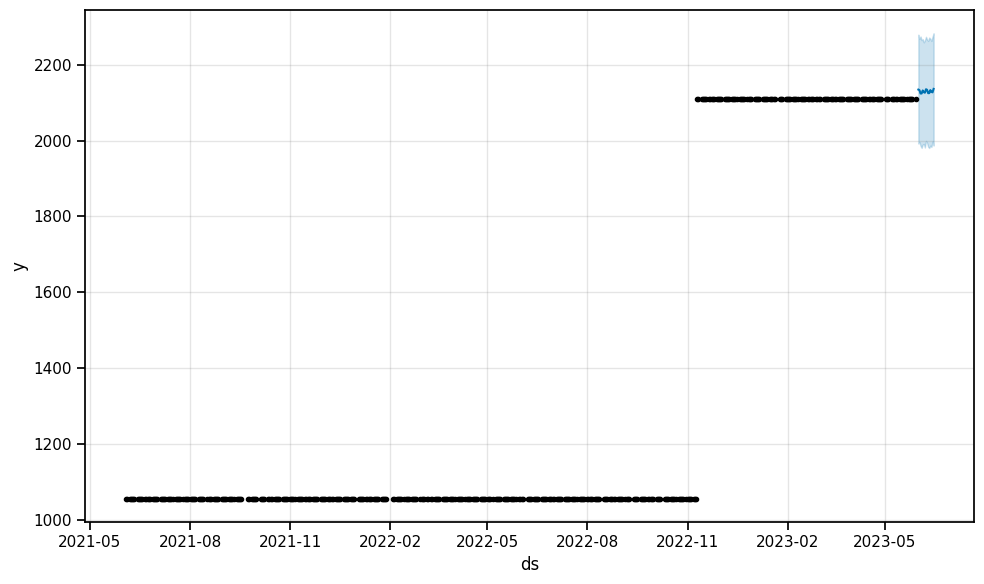

In [45]:
forecast = m.predict(last_1month_in)

m.add_seasonality(name='monthly', period=30.5, fourier_order=5)
m.plot(forecast)
plt.show()

In [ ]:

y_true = df['y'][-12:].values

# 모델 생성 후 학습
m = Prophet()
m.fit(df)

# train set 마지막 1년 날짜 생성
last_1year = list()
for i in range(1, 13):
    last_1year.append(['2019-%12d' % i])
last_1year = pd.DataFrame(last_1year, columns = ['ds'])
last_1year['ds']= pd.to_datetime(last_1year['ds'])

# 예측하고 비교하기
# 여기에서는 MAE를 살펴본다.
forecast = m.predict(last_1year)
y_pred = forecast['yhat'].values
y_true


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


array([80.  , 79.85, 80.  , 79.85, 79.85, 79.85, 79.85, 79.85, 85.35,
       84.2 , 81.6 , 80.5 ])

In [ ]:
y_pred

# 5.Model 평가



*   testset의 마지막 12개월을 테스트 셋으로 빼서 학습




In [ ]:
 # 마지막 12개월 제외시키기

y_true = df['y'][-12:].values

# 모델 생성 후 학습
m = Prophet()
m.fit(train)

# train set 마지막 1년 날짜 생성
last_1year = list()
for i in range(1, 13):
    last_1year.append(['2019-%12d' % i])
last_1year = pd.DataFrame(last_1year, columns = ['ds'])
last_1year['ds']= pd.to_datetime(last_1year['ds'])

# 예측하고 비교하기
# 여기에서는 MAE를 살펴본다.
forecast = m.predict(last_1year)
y_pred = forecast['yhat'].values
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
mae = mean_absolute_error(y_true, y_pred)
mape = mean_absolute_percentage_error(y_true, y_pred)

print('MAE: %.3f' % mae)
print('MAPE: %.3f' % mape)
# MAE가 작을수록 좋은 모델이다.


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


MAE: 8.872

MAPE: 0.110


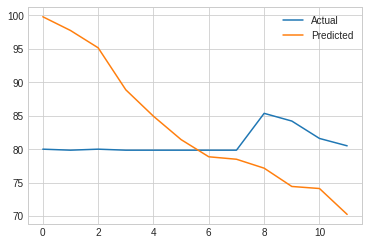

In [ ]:
pyplot.plot(y_true, label='Actual')
pyplot.plot(y_pred, label='Predicted')
pyplot.legend()
pyplot.show()

# 6.Prameter조정

1.   Trend

*   **changepoints**	트렌드 변화시점을 명시한 리스트값
*  **changepoint_prior_scale**	changepoint(trend) 의 유연성 조절
*   **n_changepoints**	changepoint 의 개수
*   **changepoint_range**	changepoint 설정 가능 범위. (기본적으로 데이터 중 80% 범위 내에서 changepoint를 설정합니다.)


2.   **Seasonality**
*  **yearly_seasonality**	연 계절성
*  **weekly_seasonality**	주 계절성
*  **daily_seasonality**	일 계절성
*  **seasonality_prior_scale**	계절성 반영 강도
*  **seasonality_mode**	‘additive ‘ 인지 ‘multiplicative’ 인지


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


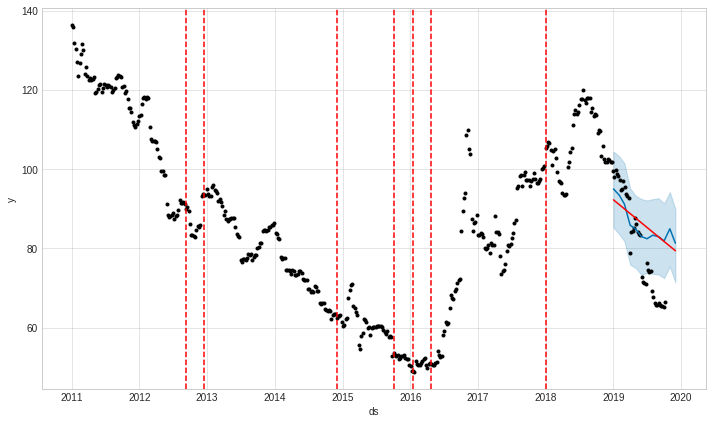

In [ ]:
 # 마지막 3개월 제외시키기
train = df.drop(df.index[-12:])
y_true = df['y'][-12:].values


# train set 마지막 1년 날짜 생성
last_1year = list()
for i in range(1, 13):
    last_1year.append(['2019-%12d' % i])
last_1year = pd.DataFrame(last_1year, columns = ['ds'])
last_1year['ds']= pd.to_datetime(last_1year['ds'])

# 모델 생성 후 학습
m = Prophet()
m.fit(train)

# train set 마지막 1년 날짜 생성
last_1year = list()
for i in range(1, 13):
    last_1year.append(['2019-%12d' % i])
last_1year = pd.DataFrame(last_1year, columns = ['ds'])
last_1year['ds']= pd.to_datetime(last_1year['ds'])

from fbprophet.plot import add_changepoints_to_plot
# changepoint_prior_scale = 0.05 (default)
fig = m.plot(forecast)

a = add_changepoints_to_plot(fig.gca(), m, forecast)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


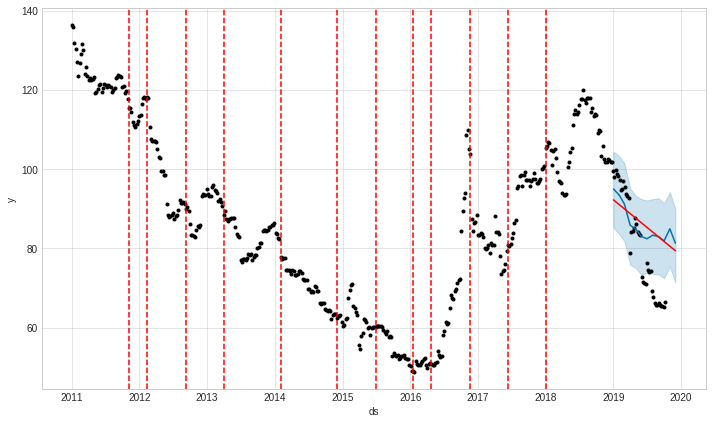

In [ ]:
m = Prophet(changepoint_prior_scale=0.3)
m.fit(train)

fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m, forecast)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


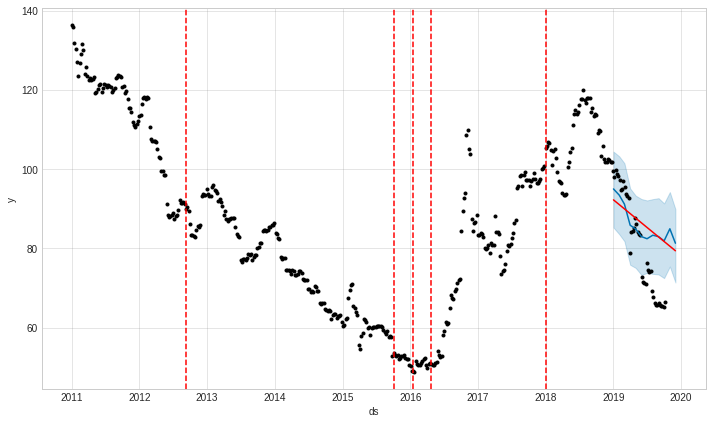

In [ ]:
m = Prophet(changepoint_prior_scale=0.1)
m.fit(train)

fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m, forecast)

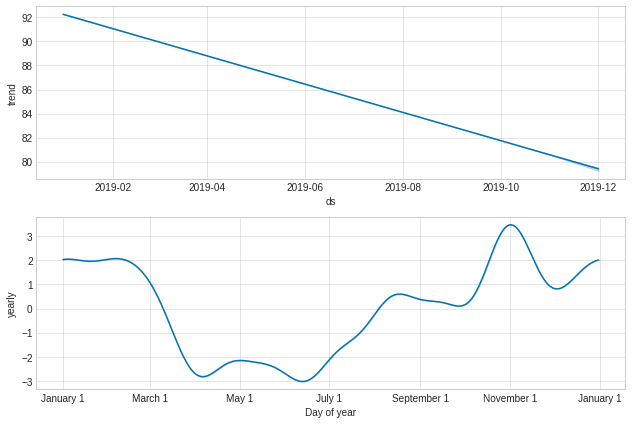

In [ ]:
m = Prophet(
    # trend
    changepoint_prior_scale=0.3,
    # seasonality
    weekly_seasonality=10,
    yearly_seasonality=10,
    daily_seasonality=False)
m.fit(train)
fig = m.plot_components(forecast)

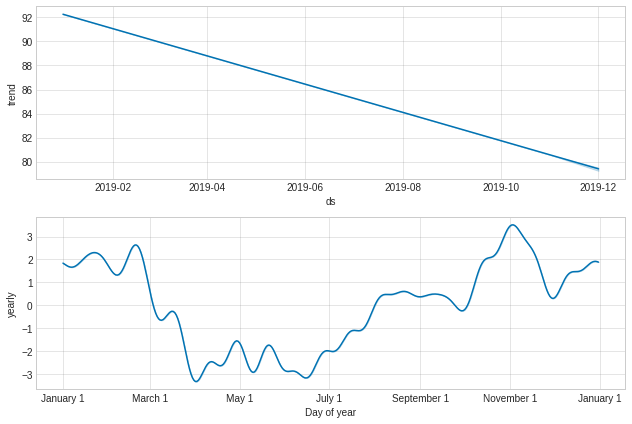

In [ ]:
# yearly_seasonality = 10 (default)
m = Prophet(
    # trend
    changepoint_prior_scale=0.3,
    # seasonality
    weekly_seasonality=10,
    yearly_seasonality=20,
    daily_seasonality=False,)
m.fit(train)
fig = m.plot_components(forecast)

monthly는 제공되지 않아서 모델에 정의해서 반영


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


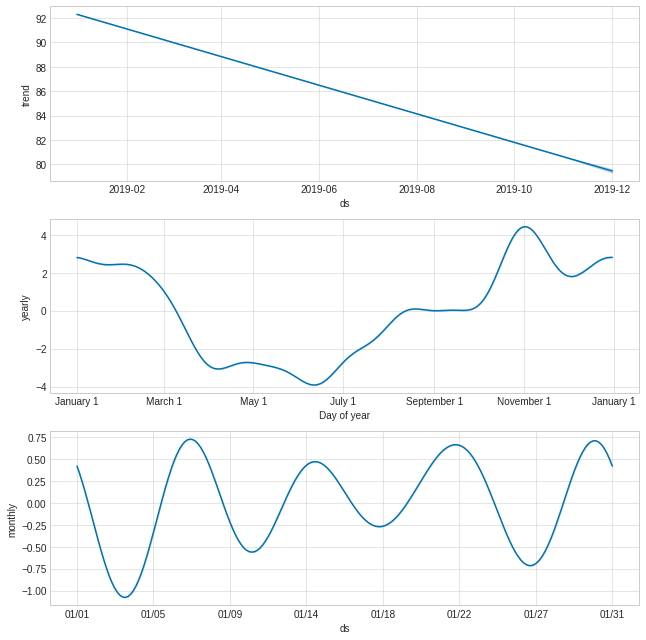

In [ ]:
m = Prophet(weekly_seasonality=False)
m.add_seasonality(name='monthly', period=30.5, fourier_order=5)
forecast = m.fit(train).predict(last_1year)
fig = m.plot_components(forecast)

# 주기가 30.5일 fourier oder가 5

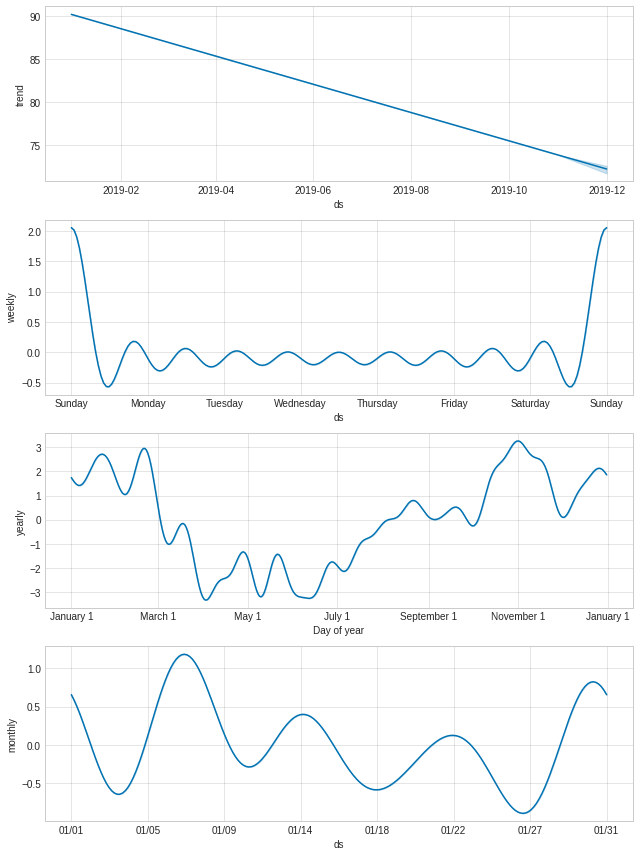

In [ ]:
m = Prophet(
    # trend
    changepoint_prior_scale=0.3,
    # seasonality
    weekly_seasonality=10,
    yearly_seasonality=20,
    daily_seasonality=False,)
m.add_seasonality(name='monthly', period=30.5, fourier_order=5)
forecast = m.fit(train).predict(last_1year)
fig = m.plot_components(forecast)

# 주기가 30.5일 fourier oder가 5

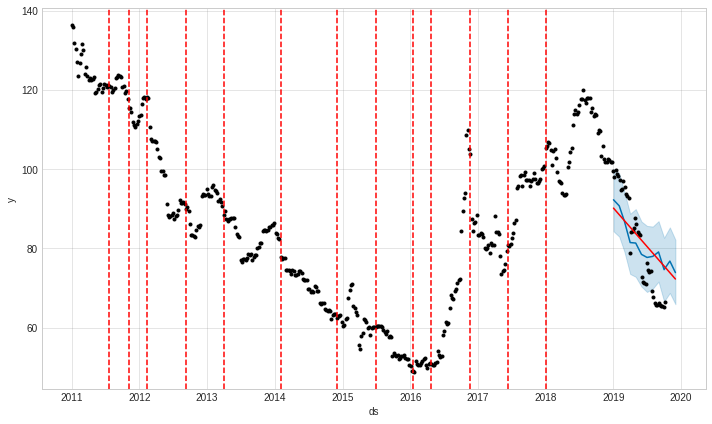

In [ ]:
fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m, forecast)

In [ ]:
# train set 이후 1년 날짜 생성
last_1year = list()
for i in range(1, 13):
    last_1year.append(['2019-%12d' % i])
last_1year = pd.DataFrame(last_1year, columns = ['ds'])
last_1year['ds']= pd.to_datetime(last_1year['ds'])

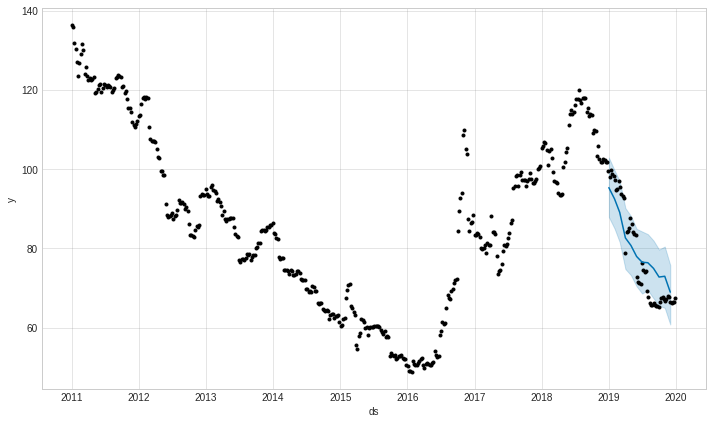

In [ ]:
forecast = m.predict(last_1year)
a = add_changepoints_to_plot(fig.gca(), m, forecast)
m.plot(forecast)
pyplot.show()


# 6.1 Prameter/train 기간조정

1.   Trend

*   **changepoints**	트렌드 변화시점을 명시한 리스트값
*  **changepoint_prior_scale**	changepoint(trend) 의 유연성 조절
*   **n_changepoints**	changepoint 의 개수
*   **changepoint_range**	changepoint 설정 가능 범위. (기본적으로 데이터 중 80% 범위 내에서 changepoint를 설정합니다.)


2.   **Seasonality**
*  **yearly_seasonality**	연 계절성
*  **weekly_seasonality**	주 계절성
*  **daily_seasonality**	일 계절성
*  **seasonality_prior_scale**	계절성 반영 강도
*  **seasonality_mode**	‘additive ‘ 인지 ‘multiplicative’ 인지


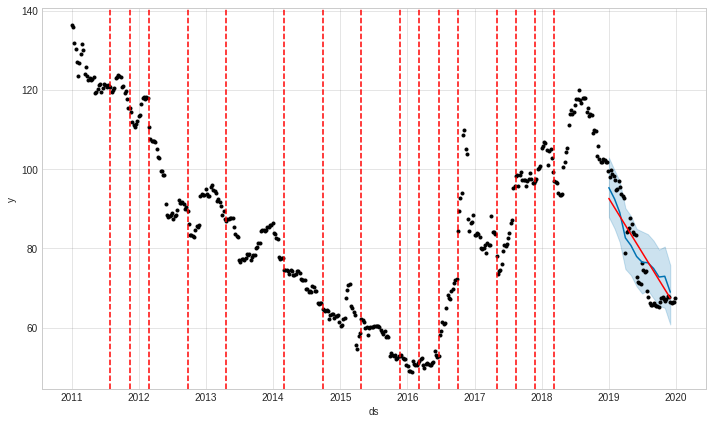

In [ ]:
from fbprophet.plot import add_changepoints_to_plot
# changepoint_prior_scale = 0.05 (default)
fig = m.plot(forecast)

a = add_changepoints_to_plot(fig.gca(), m, forecast)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


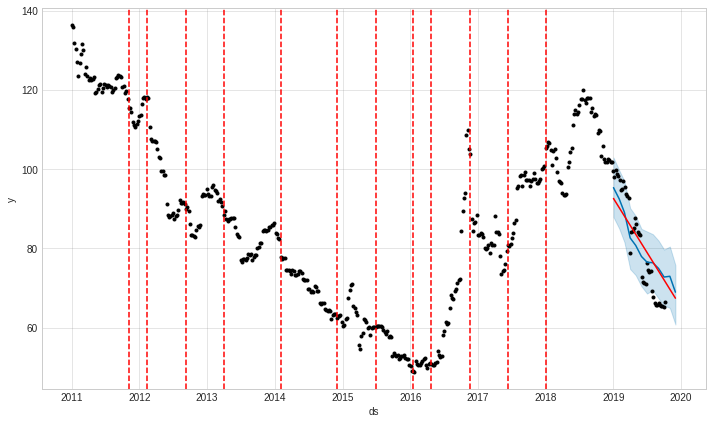

In [ ]:
m = Prophet(changepoint_prior_scale=0.3)
m.fit(train)

fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m, forecast)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


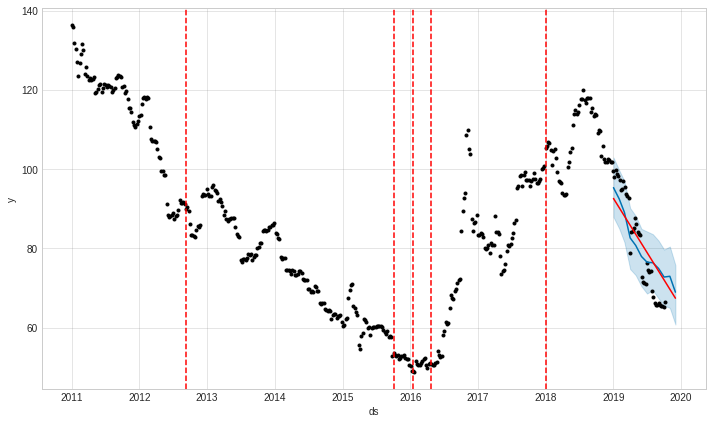

In [ ]:
m = Prophet(changepoint_prior_scale=0.1)
m.fit(train)

fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m, forecast)

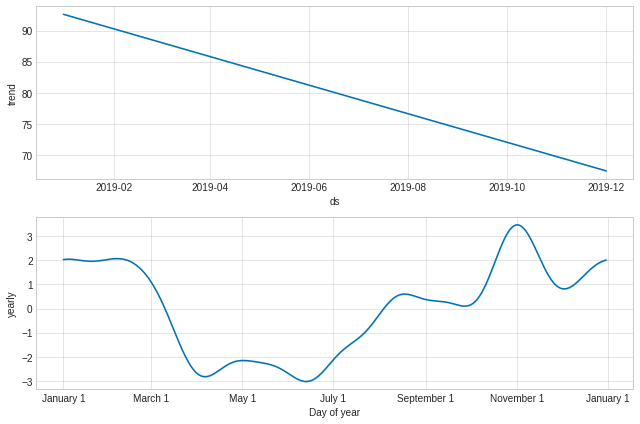

In [ ]:
m = Prophet(
    # trend
    changepoint_prior_scale=0.3,
    # seasonality
    weekly_seasonality=10,
    yearly_seasonality=10,
    daily_seasonality=False)
m.fit(train)
fig = m.plot_components(forecast)

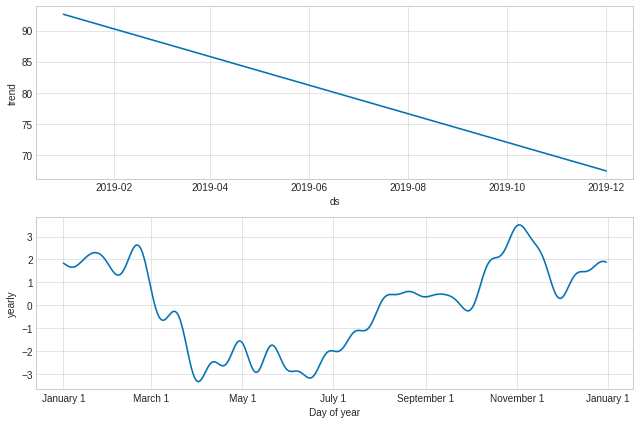

In [ ]:
# yearly_seasonality = 10 (default)
m = Prophet(
    # trend
    changepoint_prior_scale=0.3,
    # seasonality
    weekly_seasonality=10,
    yearly_seasonality=20,
    daily_seasonality=False,)
m.fit(train)
fig = m.plot_components(forecast)

monthly는 제공되지 않아서 모델에 정의해서 반영


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


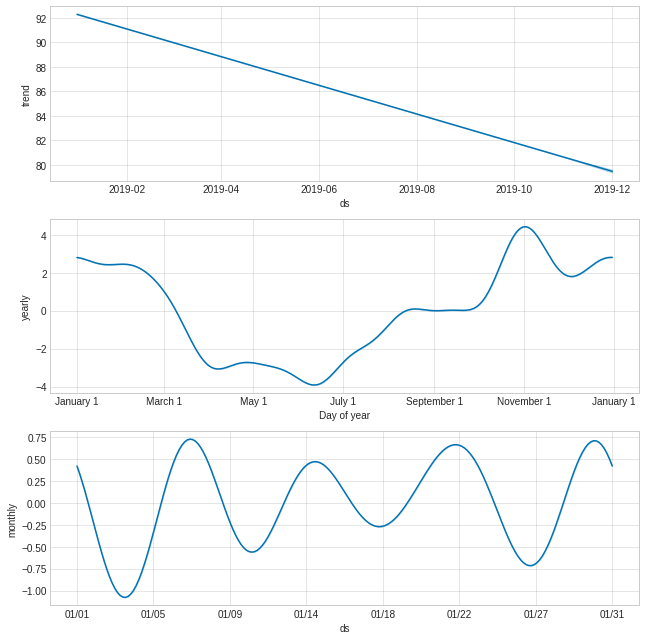

In [ ]:
m = Prophet(weekly_seasonality=False)
m.add_seasonality(name='monthly', period=30.5, fourier_order=5)
forecast = m.fit(train).predict(last_1year)
fig = m.plot_components(forecast)

# 주기가 30.5일 fourier oder가 5

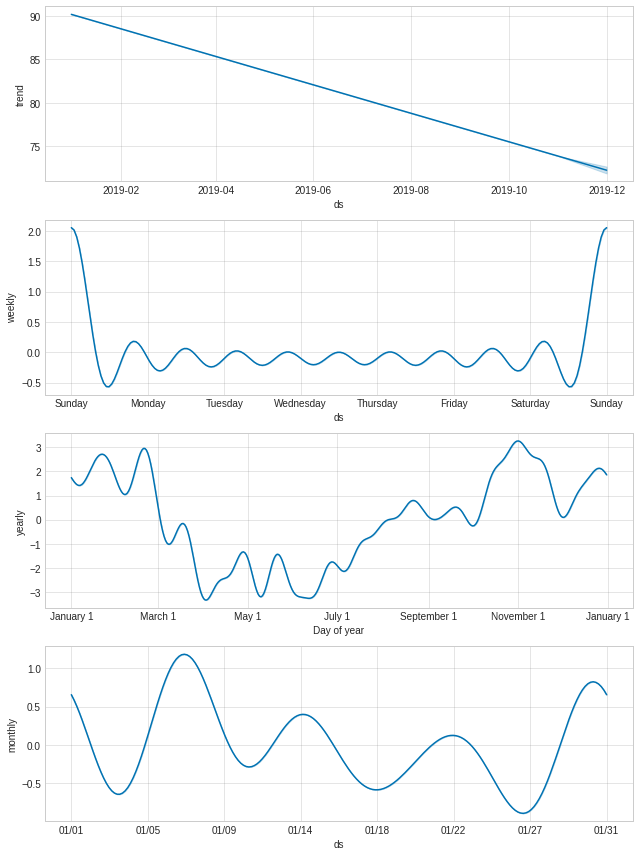

In [ ]:
m = Prophet(
    # trend
    changepoint_prior_scale=0.3,
    # seasonality
    weekly_seasonality=10,
    yearly_seasonality=20,
    daily_seasonality=False,)
m.add_seasonality(name='monthly', period=30.5, fourier_order=5)
forecast = m.fit(train).predict(last_1year)
fig = m.plot_components(forecast)

# 주기가 30.5일 fourier oder가 5

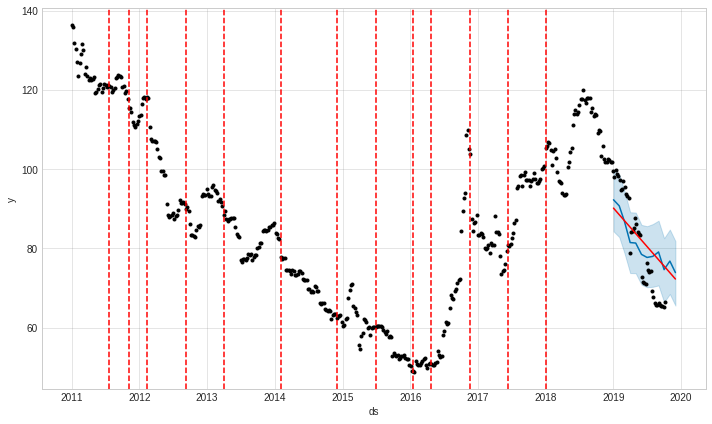

In [ ]:
fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m, forecast)

In [ ]:
# train set 이후 1년 날짜 생성
last_1year = list()
for i in range(1, 13):
    last_1year.append(['2020-%12d' % i])
last_1year = pd.DataFrame(last_1year, columns = ['ds'])
last_1year['ds']= pd.to_datetime(last_1year['ds'])

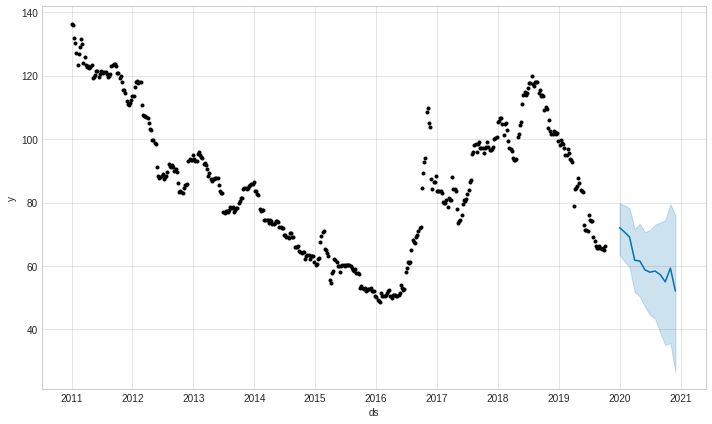

In [ ]:
forecast = m.predict(last_1year)
a = add_changepoints_to_plot(fig.gca(), m, forecast)
m.plot(forecast)
pyplot.show()
